# Анализ пользовательской воронки

## **Цель блокнота**
- изучить воронку пользовательских действий от первой успешной транзакции к повторной, выявить основной этап потери пользователей

`User` → `First Successful Order` → `Second Successful Order`




##**1. Подготовка данных**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
customers = pd.read_csv(
    "olist_customers_dataset.csv")

orders = pd.read_csv(
    "olist_orders_dataset.csv",
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date"
    ],
    dtype={
        "order_id": "string",
        "customer_id": "string",
        "order_status": "string"
    }
)

payments = pd.read_csv(
    "olist_order_payments_dataset.csv")

items = pd.read_csv(
    "olist_order_items_dataset.csv",
    parse_dates=["shipping_limit_date"]
)

customers_unique = customers[["customer_id", "customer_unique_id"]]
orders_users = orders.merge(
    customers_unique,
    on="customer_id",
    how="left")

delivered_orders = orders_users[
    orders_users["order_status"] == "delivered"].copy()


In [19]:
user_orders = (
    delivered_orders.groupby("customer_unique_id").agg(
        orders_cnt=("order_id", "nunique"),
        first_order_date=("order_purchase_timestamp", "min")).reset_index()
)

## **2. Этапы воронки**

In [20]:
# Все пользователи с хотя бы одной успешной транзакцией
users_with_order = user_orders.shape[0]
users_with_order

93358

In [29]:
# Пользователи с повторными транзакциями
users_with_second_order = user_orders[user_orders["orders_cnt"] > 1].shape[0]

users_with_third_order = user_orders[user_orders["orders_cnt"] > 2].shape[0]

users_with_fourth_order = user_orders[user_orders["orders_cnt"] > 3].shape[0]

users_with_fifth_order = user_orders[user_orders["orders_cnt"] > 4].shape[0]

In [30]:
funnel = pd.DataFrame({
    "stage": [
        "Users with first successful order",
        "Users with second successful order",
        "Users with third successful order",
        "Users with fourth successful order",
        "Users with fifth successful order",
    ],
    "users": [
        users_with_order,
        users_with_second_order,
        users_with_third_order,
        users_with_fourth_order,
        users_with_fifth_order
    ]})

funnel["conversion_from_previous"] = (
    funnel["users"] / funnel["users"].shift(1))

funnel


,stage,users,conversion_from_previous
0,Users with first successful order,93358,NaN
1,Users with second successful order,2801,0.030003
2,Users with third successful order,228,0.081400
3,Users with fourth successful order,47,0.206140
4,Users with fifth successful order,19,0.404255


Основной отвал пользователей происходит между первой и второй успешной транзакцией (конверсия ~3%).
При этом дальнейшие этапы воронки демонстрируют растущую конверсию, что говорит о формировании
устойчивого пользовательского поведения после повторного использования продукта.
Таким образом, фокус продуктовых улучшений должен быть направлен на пост-первичную активацию.


In [33]:
# Найдем дату второго заказа
second_orders = (
    delivered_orders
    .sort_values("order_purchase_timestamp")
    .groupby("customer_unique_id")
    .nth(1)
    .reset_index()
    [["customer_unique_id", "order_purchase_timestamp"]]
    .rename(columns={"order_purchase_timestamp": "second_order_date"})
)


In [34]:
# Время между первым и вторым заказом
user_orders = user_orders.merge(
    second_orders,
    on="customer_unique_id",
    how="left")

user_orders["days_between_orders"] = (
    user_orders["second_order_date"]
    - user_orders["first_order_date"]).dt.days


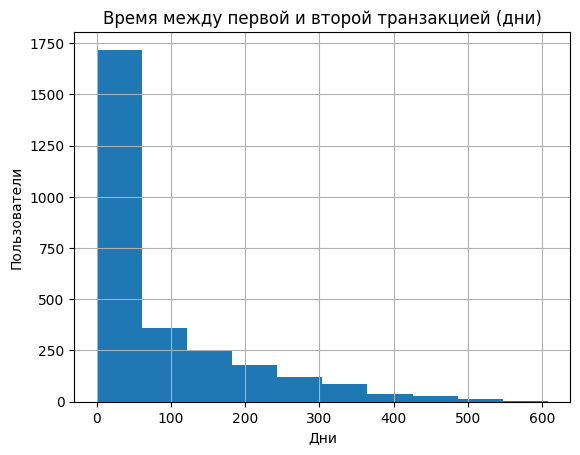

In [37]:
# Посмотрим на распределение
plt.figure()
user_orders["days_between_orders"].dropna().hist(bins=10)
plt.title("Время между первой и второй транзакцией (дни)")
plt.xlabel("Дни")
plt.ylabel("Пользователи")
plt.show()


Идея: если пользователь не вернулся в первые ~50 дней, он почти не возвращается

## **3. Выручка**
Покажем, что пользователи с повторной транзакцией ценнее

In [44]:
user_revenue = (
    delivered_orders.merge(
        payments.groupby("order_id")["payment_value"].sum().reset_index(),
        on="order_id",
        how="left").groupby("customer_unique_id")["payment_value"].sum().reset_index(name="total_revenue")
)

user_orders = user_orders.merge(
    user_revenue,
    on="customer_unique_id",
    how="left"
)
user_orders.groupby("segment")["total_revenue"].mean()


,total_revenue
segment,
one_time_users,160.761781
repeat_users,308.588793


Средняя выручка на пользователя с повторными транзакциями
существенно выше, чем у пользователей с одной транзакцией.
Таким образом, удержание пользователей оказывает прямое влияние
на LTV и является приоритетным направлением продуктовых улучшений.


## **4. Основные выводы**
1. Значительная часть пользователей не совершает вторую транзакцию
2. Повторная транзакция, как правило, происходит в первые дни
3. Ключевая проблема - недостаточная мотивация пользователей вернуться после первого использования